### Milestone 5: Final Report

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy import ndimage, misc

import keras
from keras import backend as K
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import roc_curve, hamming_loss, average_precision_score, recall_score, precision_score, f1_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.decomposition import PCA
from sklearn import preprocessing

#from IPython.display import SVG
import matplotlib
import matplotlib.pyplot as plt

import string
import time
from datetime import datetime
from __future__ import division



%matplotlib inline

In [ ]:
"""
This notebook is an extension of Milestones 3 & 4, adding topic modeling variables,
improving the data processing pipeline, and extending the deep learning model.

Specifically, these issues were addressed:

    1.  The test set must be set aside to start with, 
        so subsequently generated training sets don't dip into it   
            
    2.  Implement training by "maxi-batches": 
            - set aside test
            - load one big train batch (~5k)
            - do one epoch of training
    
    4.  Manual image pre-processing - use scipy to load images in with 
        uniform shape and formatting (and downsample, if desired)
        
    5.  Use Precision and Recall custom fcns for metrics
    
    6.  Save Keras model and associated metadata automatically
    
    7.  Log results for TensorBoard viz
    
    8.  Functionalize calls for model building and fitting, so we can sweep configs

"""

### Data loading, munging, and topic modeling of movie overviews

In [ ]:
%cd ~/data/

### Set whether to generate dataset from scratch, or load from CSVs ###
LOAD_FROM_CSV = True
####################


if LOAD_FROM_CSV:
    
    ### Read tabular data from CSVs ###
    X_train = pd.read_csv('X_train.csv').as_matrix()
    X_test = pd.read_csv('X_test.csv').as_matrix()
    X_valid = pd.read_csv('X_valid.csv').as_matrix()
    y_train = pd.read_csv('y_train.csv', header=None).as_matrix()
    y_test = pd.read_csv('y_test.csv', header=None).as_matrix()
    y_valid = pd.read_csv('y_valid.csv', header=None).as_matrix()
    ids_train = pd.read_csv('ids_train.csv', header=None).as_matrix()
    ids_test = pd.read_csv('ids_test.csv', header=None).as_matrix()
    ids_valid = pd.read_csv('ids_validate.csv', header=None).as_matrix()

In [ ]:
### Loading and munging of tabular data ###

# We'll start by loading in all the tabular data and the multi-category labels.
# Then we'll process the data all together, to remove any movies with missing data.
# Then we'll split into train, validate, test groups, and isolate movie IDs for each


if LOAD_FROM_CSV == False:

    # Let's load all the raw data
    features = pd.read_csv('features_V1.csv')
    labels = pd.read_csv('multilabels.csv')

    #delete text-based variables, except for overview
    features = features.drop(features.columns[[1, 2, 3, 6, 12]], axis=1)

    #convert release date string to numeric year
    rd = features['release_date'].str[:4]
    rd = pd.to_numeric(rd)

    features['release_date'] = rd

    #drop adult since it is always false
    del features['adult']

    # drop missing data, duplicates and pop off labels
    feat2 = pd.concat([features, labels], axis=1)
    feat2 = feat2.drop_duplicates(subset=['id'])
    feat2 = feat2.dropna()

    labels2 = feat2.iloc[:, 515:].as_matrix()
    feat2 = feat2.iloc[:, :515]

In [ ]:
### Partition dataset into train, validate, and test sets ###

# We have a final cleaned dataset of 133,851 movies. Along with this, we start with
# 150,854 images and do a 50:25:25 split. We assume image data will be missing at
# random, so data loss should be approximately equal across splits.

if LOAD_FROM_CSV == False:

    # Split our data 50:25:25 into training, validation, and testing sets
    X_train, X_test, y_train, y_test = train_test_split(feat2, labels2, test_size=0.50, random_state=42)
    X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)
    # We will use these splits to keep the test data in a "lockbox" until final model evaluation.

    # Now pop off movie IDs from each group to use as keys
    train_ids = X_train.pop('id').as_matrix()
    valid_ids = X_valid.pop('id').as_matrix()
    test_ids = X_test.pop('id').as_matrix()

    # Extract overview text from each movie
    overview_train = X_train['overview'].tolist()
    overview_valid = X_valid['overview'].tolist()
    overview_test = X_test['overview'].tolist()

In [ ]:
# Tokenize overview text for topic modeling

def movie_tokenizer(raw, stop_words, stemmer):

        try:
            
            # Tokenize using simple whitespace
            tokens = raw.lower().encode('ascii', 'ignore').split()

            # Strip useless unicode remnants, numeric, and stop words
            # **adapted from http://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python
            stripped_tokens = [t.translate(None, string.punctuation+string.digits) for t in tokens if ((not t in stop_words) and (len(t) > 2))]
            
            # Stem tokens
            return [stemmer.stem(t) for t in stripped_tokens]


        except:
        
            # Fill in non-english or missing observations with 'unknown' value
            return ['unknown']
        

In [ ]:
# Do corpus preparation for LDA fitting

def get_overview_corpus(overview_text):
    
    # Create English stop words list (hardly any overview are in another language)
    en_stop = get_stop_words('en')

    # Eliminate genres as words to include, so as not to cheat
    full_stop = en_stop + [u'comedy', u'action', u'adventure', 
                           u'drama', u'family', u'horror', 
                           u'mystery', u'thriller', u'romance', 
                           u'crime', u'science fiction', u'fantasy', 
                           u'animation', u'history', u'war', 
                           u'music', u'documentary', u'western', u'tv movie']

    # Create stemmer
    s_stemmer = SnowballStemmer('english')


    # Loop through overview list
    texts = []
    for i in overview_text:
        texts.append(movie_tokenizer(i, full_stop, s_stemmer))

    # Put tokenized overviews into a id <-> term dictionary
    dictionary = corpora.Dictionary(texts)

    # Convert tokenized overviews into a document-term matrix - FYI, this is a SPARSE matrix!!
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    return corpus, dictionary


In [ ]:
# Fit a topic model using Latent Dirichlet Allocation.  Fitting the model can 
# take > 1hr, so we'll save the gensim model by default, to be loaded later

def fit_topic_model(overview_text, n_topics=20, doSave=True):

    print 'Constructing dictionary'
    corpus, dictionary = get_overview_corpus(overview_text)
    
    # Fit topic model using LDA
    print 'Fitting topic model'
    overview_topic_mdl = gensim.models.ldamulticore.LdaMulticore(corpus, num_topics=n_topics, id2word=dictionary, passes=20)

    if doSave: overview_topic_mdl.save('./topic_mdl')
    
    return overview_topic_mdl, corpus


In [ ]:
### Topic modeling using Overview text ###

# We perform Latent Dirichlet Allocation to try to utilize the Overview text.
# We fit the topic model to the training data, and then apply model to all
# so there's no "leakage" into the test and validation sets.


if LOAD_FROM_CSV == False:


    FIT_LDA = False
    n_topics = 20


    if FIT_LDA:
         
        from stop_words import get_stop_words
        from nltk.stem.porter import PorterStemmer
        from nltk.stem.snowball import SnowballStemmer
        from gensim import corpora, models
        import gensim

        # Fit a topic model to the training data.  The resulting model will be 
        # applied to validation and test data as well. Note: takes 1h+ to fit!
        overview_topic_mdl, corpus = fit_topic_model(overview_train, n_topics)

    else:

        # load existing model
        overview_topic_mdl = gensim.models.ldamodel.LdaModel.load('./topic_mdl')
        corpus, dictionary = get_overview_corpus(overview_train)



    # Now apply topic model to each dataset partition to get estimated topic loadings
    # and append these values as to data matrix as new features

    # --- Training set
    tpx = gensim.matutils.corpus2dense(overview_topic_mdl[corpus], n_topics)

    # Now append to existing data matrix
    tpx_df = pd.DataFrame(tpx.transpose(), index=range(len(corpus)))
    X_train.index = range(len(corpus))
    X_train = pd.concat([X_train, tpx_df], ignore_index=True, axis=1)
    X_train = X_train.drop(X_train.columns[[1]], axis=1)


    # --- Validation set
    corpus, dictionary = get_overview_corpus(overview_valid)
    tpx = gensim.matutils.corpus2dense(overview_topic_mdl[corpus], n_topics)

    # Now append to existing data matrix
    tpx_df = pd.DataFrame(tpx.transpose(), index=range(len(corpus)))
    X_valid.index = range(len(corpus))
    X_valid = pd.concat([X_valid, tpx_df], ignore_index=True, axis=1)
    X_valid = X_valid.drop(X_valid.columns[[1]], axis=1)


    # --- Test set
    corpus, dictionary = get_overview_corpus(overview_test)
    tpx = gensim.matutils.corpus2dense(overview_topic_mdl[corpus], n_topics)

    # Now append to existing data matrix
    tpx_df = pd.DataFrame(tpx.transpose(), index=range(len(corpus)))
    X_test.index = range(len(corpus))
    X_test = pd.concat([X_test, tpx_df], ignore_index=True, axis=1)
    X_test = X_test.drop(X_test.columns[[1]], axis=1)

Now, at this point, we've assembled our final data matrices for each of the sets, complete with topic model loadings.  Next we'll start dealing with the image data.  Most, but not all, movies have posters. Similarly, some movies with posters have been excluded because of other missing features.  We'll need to reconcile these discrepancies by loading images and checking their formatting.  Any exceptions will cause the movie to be excluded.

In [ ]:
# Create multi-label metrics to evaluate performance.
# These functionas calculate metric within each observation, 
# and average across observations -just what we need.

def multi_recall(y_true, y_pred):
    return recall_score(y_true, y_pred, average='samples')

def multi_precision(y_true, y_pred):
    return precision_score(y_true, y_pred, average='samples')

def multi_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='samples')

In [ ]:
# Fit RFC on non-image features set and calculate multilabel performance metrics on validation set
# We'll hold out the test set until the very end

DO_PCA = False

if DO_PCA:
    N_PCs = 100
    # Standardize data
    scaler = preprocessing.StandardScaler().fit(X_train)
    
    # Do PCA, retaining the first N_PCs components
    pca = PCA(n_components=N_PCs)
    pca.fit(scaler.transform(X_train))
    
    # Fit RFC on PCs using optimal hyperparameters found from tuning on validation set
    rfc_mdl = RFC(n_estimators=300, max_depth=20, max_features=N_PCs, n_jobs=-1).fit(pca.transform(scaler.transform(X_train)), y_train)
    rf_pred = rfc_mdl.predict(pca.transform(scaler.transform(X_valid)))

else:
    # Fit RFC using optimal hyperparameters found from tuning on validation set
    rfc_mdl = RFC(n_estimators=300, max_depth=20, max_features=533, n_jobs=-1).fit(X_train, y_train)
    rf_pred = rfc_mdl.predict(X_valid)

In [32]:
print multi_recall(y_valid, rf_pred)
print multi_precision(y_valid, rf_pred)
print multi_f1(y_valid, rf_pred)

0.415387269018
0.526327893768
0.445691701807


In [255]:
### Tune RFC model using validation set ###

# n_estimators=300, max_depth=20, and max_features=533 seems to be optimal (8min run time)

r = []
p = []
f1 = []

for n in [10, 20, 50, 100, 200, 300]:
    
    for d in [10, 20, 50, 100, 200, 300]:
        
        for f in [10, 25, 50, 100, 200, 300, 500, 533]:

            rfc_mdl = RFC(n_estimators=n, max_depth=d, max_features=f, n_jobs=-1).fit(X_train, y_train)
            rf_pred = rfc_mdl.predict(X_valid)

            r.append(multi_recall(y_valid, rf_pred))
            p.append(multi_precision(y_valid, rf_pred))
            f1.append(multi_f1(y_valid, rf_pred))

            print 'n_estimators = {n}, max_depth = {d}, max_features = {f}'.format(n=n,d=d,f=f)
            print multi_recall(y_valid, rf_pred)
            print multi_precision(y_valid, rf_pred)
            print multi_f1(y_valid, rf_pred)

CPU times: user 26min 59s, sys: 12.5 s, total: 27min 11s
Wall time: 7min 51s
n_estimators = 300, max_depth = 20, max_features = 533
0.348556782259
0.435060005957
0.369707389456


In [269]:
### Evaluate RFC on held out test data ###
rf_pred = rfc_mdl.predict(X_test)

print multi_precision(y_test, rf_pred)
print multi_recall(y_test, rf_pred)
print multi_f1(y_test, rf_pred)
print hamming_loss(y_test, rf_pred)

### Compare metrics with random data ###
y_probs = y_train.mean(axis=0)

random_data = np.column_stack((np.random.binomial(1,y_probs[0],(y_test.shape[0],1)),
                             np.random.binomial(1,y_probs[1],(y_test.shape[0],1)),
                             np.random.binomial(1,y_probs[2],(y_test.shape[0],1)),
                             np.random.binomial(1,y_probs[3],(y_test.shape[0],1)),
                             np.random.binomial(1,y_probs[4],(y_test.shape[0],1)),
                             np.random.binomial(1,y_probs[5],(y_test.shape[0],1)),
                             np.random.binomial(1,y_probs[6],(y_test.shape[0],1))))

print '\n'
print multi_precision(y_test, random_data)
print multi_recall(y_test, random_data)
print multi_f1(y_test, random_data)
print hamming_loss(y_test, random_data)

0.447149198663
0.349975498674
0.376083411573
0.192596893479


0.265651062685
0.303943752642
0.258254682018
0.300929815025


In [72]:
# Generate maxi-batches
def get_train_batch(batch_size=3200, verbose=True):
    
    STANDARDIZE_IMAGES = True

    # Randomly select a maxi-batch of images
    idx_batch = np.random.choice(np.arange(len(ids_train)), size=batch_size, replace=False)

    # Get movie IDs
    ids_batch = ids_train[idx_batch]

    # Get labels
    y_batch = y_train[idx_batch]

    # Read in images
    X_batch = np.zeros([batch_size, 300, 185, 3])

    ct = 0
    for i in ids_batch:
        IM = ndimage.imread('posters/train/{}.jpg'.format(i[0]))
        
        try:
            
            # Standardize **within** each image
            if STANDARDIZE_IMAGES:    
                # Here we just want to standardize the overall image intensity, 
                # so we convert to HSV, standardize V-channel, and then convert back to RGB
                tmp_im = matplotlib.colors.rgb_to_hsv(IM)
                tmp_im[:,:,2] = (tmp_im[:,:,2] - tmp_im[:,:,2].mean()) / tmp_im[:,:,2].std()
                IM = matplotlib.colors.hsv_to_rgb(tmp_im)
                #IM = (IM - IM.mean()) / IM.std()

            X_batch[ct,:,:,:] = IM
        
        except:
            print'Something bad happened when loading movie {}'.format(i[0])

        if verbose and (ct % 100 == 0):
            print 'poster {i}/{n} loaded'.format(i=ct+1, n=batch_size)

        ct += 1

    if verbose: print 'batch loaded'

    return X_batch, y_batch

In [73]:
# Generate maxi-batches
def get_validate_batch(batch_size=3200, verbose=True):

    STANDARDIZE_IMAGES = True
    
    # Randomly select a maxi-batch of images
    idx_batch = np.random.choice(np.arange(len(ids_valid)), size=batch_size, replace=False)

    # Get movie IDs
    ids_batch = ids_valid[idx_batch]

    # Get labels
    y_batch = y_train[idx_batch]

    # Read in images
    X_batch = np.zeros([batch_size, 300, 185, 3])

    ct = 0
    for i in ids_batch:
        IM = ndimage.imread('posters/validate/{}.jpg'.format(i[0]))

        try:
                        
            # Standardize **within** each image
            if STANDARDIZE_IMAGES:    
                # Here we just want to standardize the overall image intensity, 
                # so we convert to HSV, standardize V-channel, and then convert back to RGB
                tmp_im = matplotlib.colors.rgb_to_hsv(IM)
                tmp_im[:,:,2] = (tmp_im[:,:,2] - tmp_im[:,:,2].mean()) / tmp_im[:,:,2].std()
                IM = matplotlib.colors.hsv_to_rgb(tmp_im)
                #IM = (IM - IM.mean()) / IM.std()

            X_batch[ct,:,:,:] = IM
            
        except:
            print'Something bad happened when loading movie {}'.format(i[0])

        if verbose and (ct % 100 == 0):
            print 'poster {i}/{n} loaded'.format(i=ct+1, n=batch_size)

        ct += 1

    if verbose: print 'batch loaded'

    return X_batch, y_batch

In [74]:
# Build CNN model

model_1 = Sequential()

# input: 300x185 images with 3 channels -> (300, 185, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
# NoteL we're not completely covering the images here
model_1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 185, 3)))
model_1.add(Conv2D(32, (3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(Conv2D(64, (3, 3), activation='relu'))
model_1.add(Conv2D(64, (3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(7, activation='sigmoid'))

model_1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['binary_accuracy'])

# Other optimizer parameters
#model_1.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['binary_accuracy'])
#sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
#model_1.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])

model_1.summary()

# Visualize network graph
#SVG(model_to_dot(model_1).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 298, 183, 32)      896       
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 296, 181, 32)      9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 148, 90, 32)       0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 148, 90, 32)       0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 146, 88, 64)       18496     
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 144, 86, 64)       36928     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 72, 43, 64)        0         
__________

In [ ]:
### Fit CNN model using maxi-batches

# 200 iterations over maxi-batches gives us about 1X coverage of all training data
n_it = 300

# Write to persistent storage on EFS
TB_callback = keras.callbacks.TensorBoard(log_dir='/home/ubuntu/efs/logs')
valid_auc = []

for i in range(n_it):
    
    print i
    X_batch, y_batch = get_train_batch(320, verbose=False)

    # Run in mini-batches of size=32
    history = model_1.fit(X_batch, y_batch, batch_size=32, verbose=1, epochs=10, callbacks=[TB_callback])
    
    # Test on validation batch after each maxi-batch
    X_batch, y_batch = get_validate_batch(1024, verbose=False)
    y_pred = model_1.predict(X_batch)
    auc = roc_auc_score(y_batch, y_pred)
    valid_auc.append(auc)
    print 'ROC AUC = {}'.format(auc)

    # Save model periodically to avoid catastrophic loss
    if i % 5 == 0:
        print 'saving'
        model_1.save('/home/ubuntu/efs/conv_movie_model.h5')

# Save model at very end, too
model_1.save('/home/ubuntu/efs/conv_movie_model.h5')

In [62]:
X_batch, y_batch = get_validate_batch(10000, verbose=False)
y_pred = model_1.predict(X_batch)

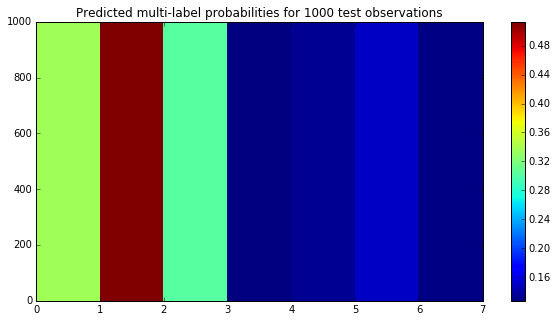

In [63]:
# This is for large batch size, high iteration model - all predicted the same
plt.figure(figsize=[10,5])
plt.pcolor(y_pred[:1000])
plt.colorbar()
plt.title('Predicted multi-label probabilities for 1000 test observations')

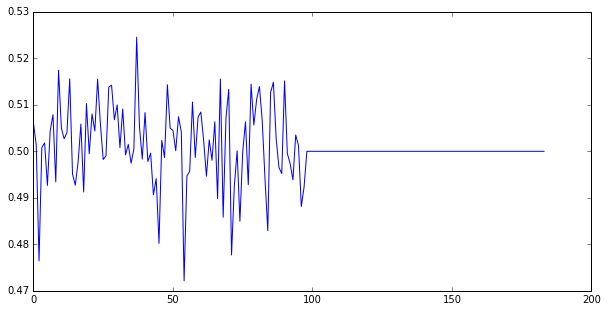

In [39]:
# Long run saved as Model_3 = maxi-batch=320, epochs=10, valid-batch=1000
plt.figure(figsize=[10,5])
plt.plot(valid_auc_long)

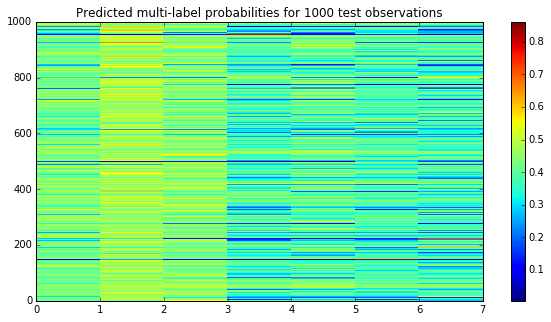

In [60]:
# This is for small batch size, low iteration model
plt.figure(figsize=[10,5])
plt.pcolor(y_pred[:1000])
plt.colorbar()
plt.title('Predicted multi-label probabilities for 1000 test observations')

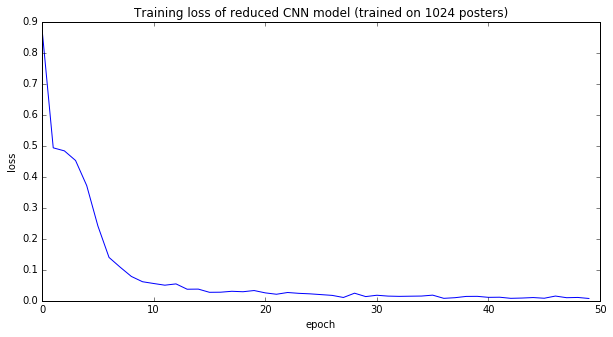

In [67]:
# This is for small batch size, low iteration model
plt.figure(figsize=[10, 5])
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Training loss of reduced CNN model (trained on 1024 posters)')



0.497124822411


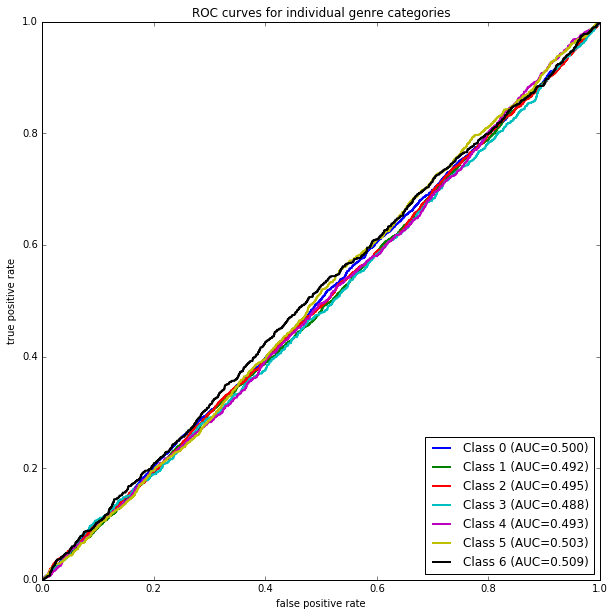

In [56]:
# Plot ROC curves for each genre category
plt.figure(figsize=[10,10])
plt.hold

for i in range(7):
    fpr, tpr, thresholds = roc_curve(y_batch[:,i], y_pred[:,i])
    score = roc_auc_score(y_batch[:,i], y_pred[:,i])
    plt.plot(fpr, tpr, lw=2, label='Class {c} (AUC={auc:.3f})'.format(c=i, auc=score))

plt.legend(loc=4)
plt.title('ROC curves for individual genre categories')
plt.xlabel('false positive rate'); plt.ylabel('true positive rate')

score = roc_auc_score(y_batch, y_pred)
print '\n'
print score